In [ ]:
# !pip install tensorflow

In [ ]:
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [ ]:
def read_and_decode(filename, resize_dims):
    # 1. Read the raw file
    img_bytes = tf.io.read_file(filename)
    # 2. Decode image data
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # 3. Convert pixel values to floats in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize the image to match desired dimensions
    img = tf.image.resize(img, resize_dims)
    return img

In [ ]:
def parse_csvline(csv_line):
    # record_defaults specify the data types for each column
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    # Load the image
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Convert label string to integer based on the CLASS_NAMES index
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [ ]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for image_batch, label_batch in train_dataset.take(3):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]
Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [0 3 2 1 0 4 2 0 2 2 1 3 3 2 1 0]
Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [3 1 1 1 1 0 1 2 4 3 3 2 0 1 4 0]


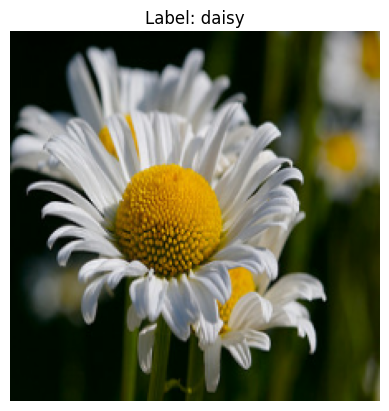

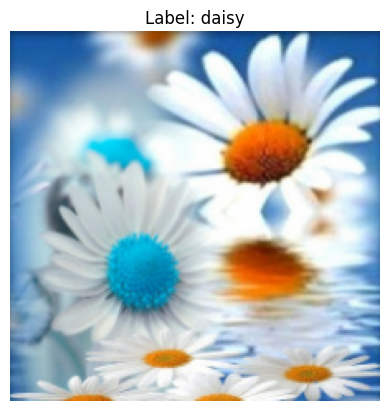

In [ ]:
import matplotlib.pyplot as plt

for image_batch, label_batch in train_dataset.take(2):
    # Take the first image from the batch
    first_image = image_batch[0]
    first_label = label_batch[0]

    # Convert tensor to numpy array
    plt.imshow(first_image.numpy())
    plt.title(f"Label: {CLASS_NAMES[first_label]}")
    plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for image_batch, label_batch in train_dataset.take(2):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4x4 grid

    for i in range(16):  # Loop over the first 16 images
        ax = axes[i // 4, i % 4]  # Determine grid position
        ax.imshow(image_batch[i].numpy())  # Convert tensor to numpy array
        ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
        ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()


In [ ]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCHS
)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 119s 572ms/step - accuracy: 0.4853 - loss: 9.0499 - val_accuracy: 0.3730 - val_loss: 13.8992
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 156s 747ms/step - accuracy: 0.4644 - loss: 11.4667 - val_accuracy: 0.4270 - val_loss: 15.7491
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 126s 602ms/step - accuracy: 0.5261 - loss: 8.6735 - val_accuracy: 0.4216 - val_loss: 17.6172
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 117s 561ms/step - accuracy: 0.4853 - loss: 11.8379 - val_accuracy: 0.3703 - val_loss: 16.3229
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 117s 559ms/step - accuracy: 0.5371 - loss: 9.4539 - val_accuracy: 0.3919 - val_loss: 19.4219
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 116s 556ms/step - accuracy: 0.5206 - loss: 11.0869 - val_accuracy: 0.4378 - val_loss: 11.1338
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 115s 552ms/step - accuracy: 0.6134 - loss: 5.8584 - val_accuracy: 0.4351 - val_loss: 14.8742
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 113s 544ms/step - accuracy

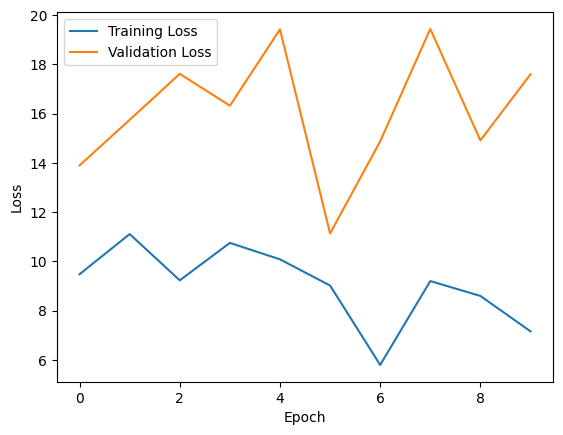

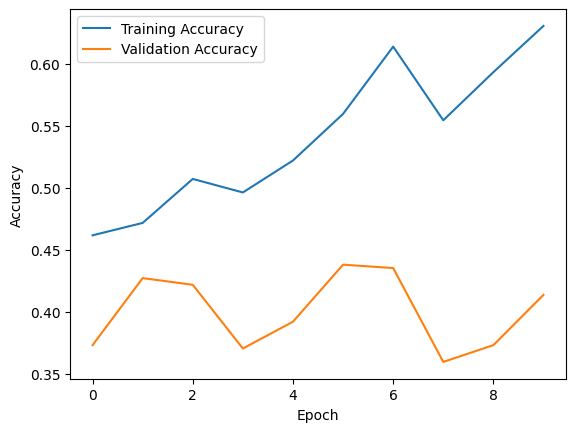

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in eval_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()